In [1]:
import numpy as np
import gymnasium as gym
import pathlib

from tensoraerospace.agent.pid import PID
from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid
from tensoraerospace.benchmark.function import overshoot, settling_time, static_error

In [2]:
dt = 0.01  # Дискретизация
tp = generate_time_period(tn=20, dt=dt) # Временной периуд
tps = convert_tp_to_sec_tp(tp, dt=dt)
number_time_steps = len(tp) # Количество временных шагов
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=10, output_rad=True), [1, -1]) # Заданный сигнал

pid_config = {'ki': -0.6465002150926438,
 'kp': -20.410120034380714,
 'kd': -6.070487412521423}


In [36]:
# Инициализация списка для хранения исторических данных
hist = []
dt = 0.01  # Интервал дискретизации времени

# Генерация временного периода с заданным интервалом дискретизации
tp = generate_time_period(tn=80, dt=dt) 

# Конвертация временного периода в секунды
tps = convert_tp_to_sec_tp(tp, dt=dt)

# Вычисление общего количества временных шагов
number_time_steps = len(tp) 

saved_path = "./data/gail"
pathlib.Path(saved_path).mkdir(parents=True, exist_ok=True)

signals = [
    np.reshape(unit_step(degree=1, tp=tp, time_step=10, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=2, tp=tp, time_step=5, output_rad=True), [1, -1]),
    
    np.reshape(unit_step(degree=3, tp=tp, time_step=5, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=4, tp=tp, time_step=2, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=3, tp=tp, time_step=2, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=4, tp=tp, time_step=14, output_rad=True), [1, -1]),
    
    np.reshape(unit_step(degree=7, tp=tp, time_step=10, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=7, tp=tp, time_step=11, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=3, tp=tp, time_step=10, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=5, tp=tp, time_step=10, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=5, tp=tp, time_step=1, output_rad=True), [1, -1]),
    np.reshape(unit_step(degree=5, tp=tp, time_step=7, output_rad=True), [1, -1]),
]

for index, reference_signals in enumerate(signals):
    # Создание среды симуляции, задание временных шагов, начального состояния, заданного сигнала и отслеживаемых состояний
    env = gym.make('LinearLongitudinalF16-v0',
                number_time_steps=number_time_steps, 
                use_reward = False,
                initial_state=[[0],[0], [0]],
                reference_signal=reference_signals,
                state_space = [ "theta", "alpha", "q",],
                    output_space = ["theta", "alpha", "q", ],
                    tracking_states=["alpha"])

    # Сброс среды к начальному состоянию
    env.reset()

    # Инициализация ПИД-регулятора с параметрами из конфигурации
    pid = PID(env, kp=pid_config["kp"], ki=pid_config["ki"], kd=pid_config["kd"], dt=dt)

    # Начальное состояние системы
    xt, info = env.reset()
    expert_traj = []
    # Основной цикл обновления состояния системы и регулятора
    for step in range(number_time_steps - 2):
        # Получение текущего заданного значения
        setpoint = reference_signals[0, step]

        # Запись текущего угла в историю
        hist.append(xt[1])

        # Вычисление управляющего сигнала с помощью ПИД-регулятора
        ut  = pid.select_action(setpoint, xt[1])
        expert_traj.append(np.hstack([xt, np.array([ut.item()])]))
        # Обновление состояния среды с учетом управляющего сигнала
        xt, reward, terminated, truncated, info = env.step(np.array([ut.item()]))
    with open(f'{saved_path}/{index}_signal.npy', 'wb') as f:
        np.save(f, np.array(expert_traj))


In [37]:
expert_traj[-1]

array([ 3.64930387,  0.08717231,  0.0515945 , -0.23425264])

In [38]:
system_signal_orig = env.unwrapped.model.get_state('alpha', to_deg=True)[:4000]
control_signal_orig = np.rad2deg(reference_signals[0])[:4000]

In [39]:
# Вызов функции для расчета статической ошибки системы
# Входные данные: исходный управляющий сигнал и исходный сигнал системы
# Функция 'static_error' вычисляет разницу между желаемым и фактическим значением системы в установившемся режиме
static_error(control_signal_orig, system_signal_orig)

0.018338360641906526

In [40]:
# Вызов функции для расчета перерегулирования системы
# Входные данные: исходный управляющий сигнал и исходный сигнал системы
# Функция 'overshoot' определяет максимальное превышение системным сигналом его установившегося значения
overshoot(control_signal_orig, system_signal_orig)

-0.11066732217257069

In [41]:
# Вызов функции для расчета времени установления системы
# Входные данные: исходный управляющий сигнал и исходный сигнал системы
# Функция 'settling_time' определяет время, необходимое системе для достижения и поддержания значения в пределах заданного диапазона от установившегося значения
# Результат умножается на 0.01 для приведения его к соответствующему временному масштабу
settling_time(control_signal_orig, system_signal_orig) * 0.01

14.46

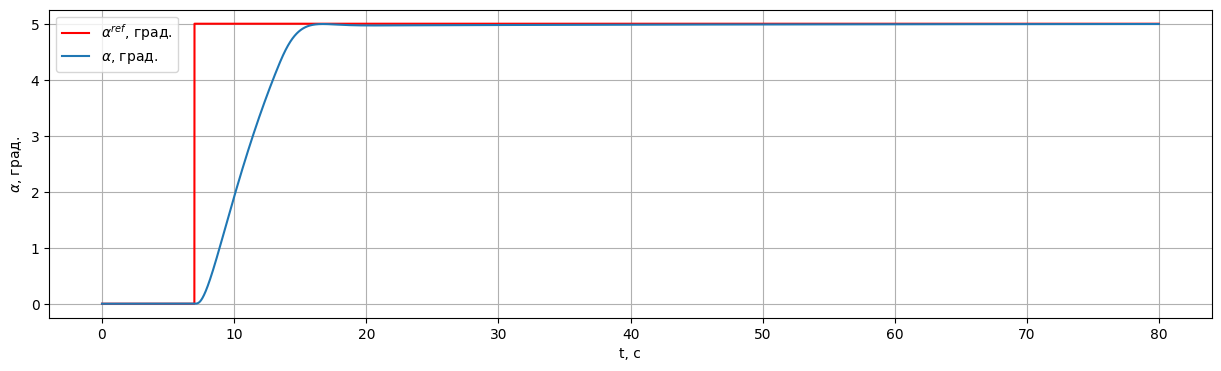

In [42]:
env.unwrapped.model.plot_transient_process('alpha', tps, reference_signals[0], to_deg=True, figsize=(15,4))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


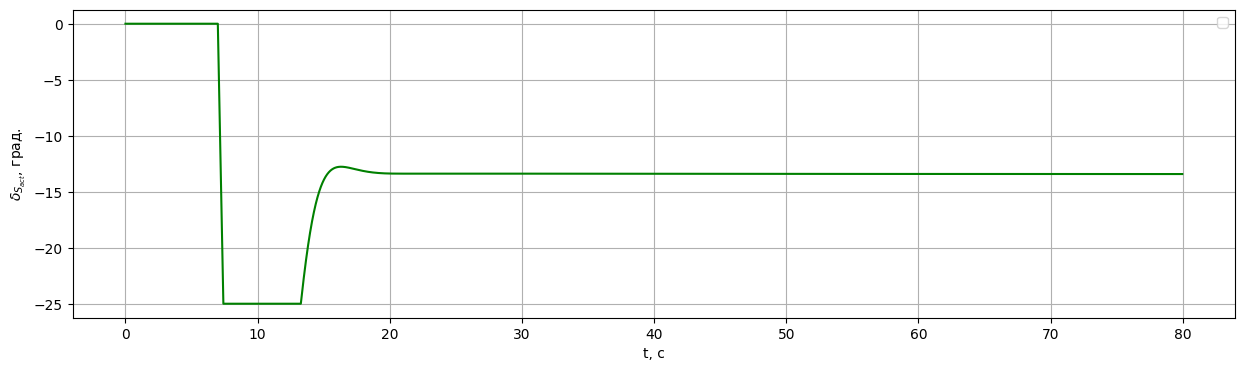

In [43]:
env.unwrapped.model.plot_control('ele', tps, to_deg=True, figsize=(15,4))

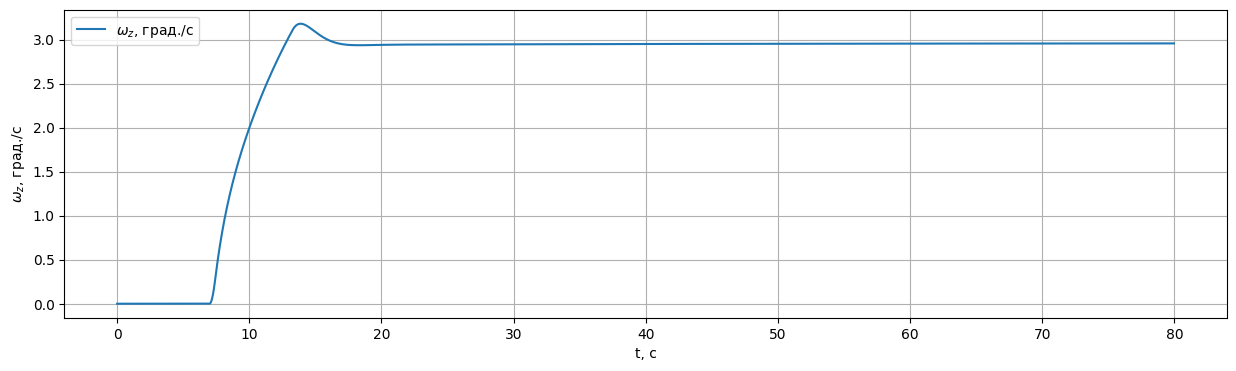

In [44]:
env.unwrapped.model.plot_state('q', tps, figsize=(15,4), to_deg=True)

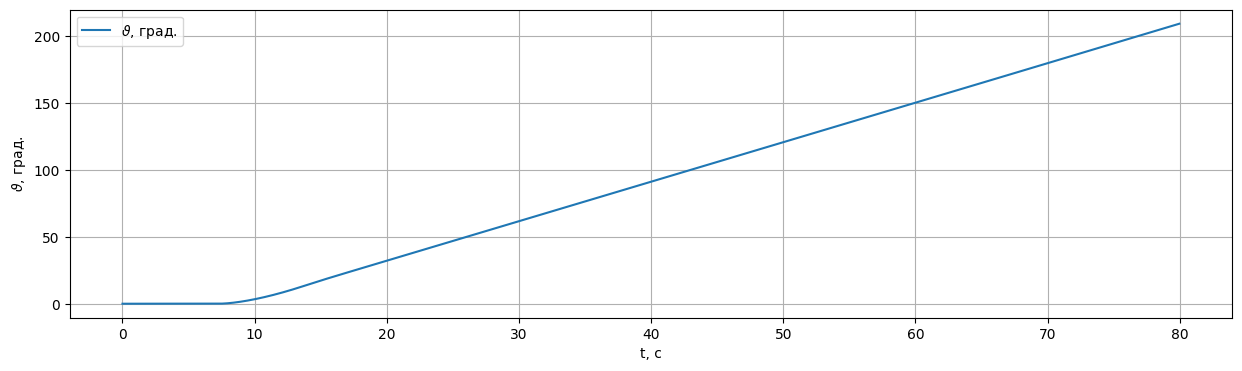

In [45]:
env.unwrapped.model.plot_state('theta', tps, figsize=(15,4), to_deg=True)

In [16]:
pid.save()

tensoraerospace.envs.f16.linear_longitudial.LinearLongitudinalF16


/Users/asmazaev/Projects/TensorAeroSpace/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_init_args to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_init_args` for environment variables or `env.get_wrapper_attr('get_init_args')` that will search the reminding wrappers.
  logger.warn(


In [13]:
agent = PID.from_pretrained("./May03_12-38-38_PID")

In [14]:
agent

In [16]:
# Начальное состояние системы
xt = np.array([[np.deg2rad(0)], [0]])
state, info = env.reset()
# Основной цикл обновления состояния системы и регулятора
for step in range(number_time_steps - 2):
    # Получение текущего заданного значения
    setpoint = reference_signals[0, step]

    # Запись текущего угла в историю
    hist.append(xt[0])

    # Вычисление управляющего сигнала с помощью ПИД-регулятора
    ut  = pid.select_action(setpoint, xt[0])

    # Обновление состояния среды с учетом управляющего сигнала
    xt, reward, terminated, truncated, info = env.step(np.array([ut.item()]))